# 1. Problem formulation:

Opis problemu

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import cmdstanpy

BINS = 20

In [14]:
audi_a3_2000ccm_standarized = pd.read_csv("data/audi_data_standarized.csv")
audi_a3_2000ccm_standarized.head()

,Price,Production_year,Mileage_km
0,0.190769,0.739130,0.472726
1,0.037814,0.434783,0.515908
2,0.071804,0.434783,0.713306
3,0.063306,0.391304,0.549999
4,0.076053,0.347826,0.545454


# 2. Model

Opis modeli

## 2.1 Model 1- prior

In [15]:
model_exp_ppc = cmdstanpy.CmdStanModel(stan_file='stan_files/exp_model_ppc.stan')

#Parameters
N = 532
mu_a =0.17
sig_a =0.02
mu_b1 = 0.36
sig_b1 = 0.02
mu_b2 = 0.36
sig_b2 = 0.02

data = {"N": N, 
        "mileage" : np.linspace(0.01,1,N),
        "production_year" : np.linspace(0.01,1,N),
        "mu_a" : mu_a,
        "sig_a" : sig_a,
        "mu_b1" : mu_b1,
        "mu_b2" : mu_b2,
        "sig_b1" : sig_b1,
        "sig_b2" : sig_b2,
        }


sim_exp_fit=model_exp_ppc.sample(data=data)
sim_exp_fit_pd = sim_exp_fit.draws_pd()
sim_exp_fit_pd.head()

22:43:21 - cmdstanpy - INFO - compiling stan file /home/car_prices_pr/DA/project/stan_files/exp_model_ppc.stan to exe file /home/car_prices_pr/DA/project/stan_files/exp_model_ppc
22:43:36 - cmdstanpy - INFO - compiled model executable: /home/car_prices_pr/DA/project/stan_files/exp_model_ppc
22:43:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration: 100 / 1000 [ 10%]  (Sampling)


chain 1 |███▏      | 00:00 Iteration: 500 / 1000 [ 50%]  (Sampling)


chain 1 |████▌     | 00:00 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


22:43:36 - cmdstanpy - INFO - CmdStan done processing.


,lp__,accept_stat__,price[1],price[2],price[3],price[4],price[5],price[6],price[7],price[8],...,price[528],price[529],price[530],price[531],price[532],alpha,beta1,beta2,sigma,lambda
0,0.0,0.0,0.672987,0.014312,0.144146,0.061797,0.178154,0.043699,0.135767,0.085978,...,0.390938,0.038875,0.288366,0.207170,0.163210,0.143181,0.369591,0.325662,0.141174,0.024795
1,0.0,0.0,0.138093,0.039336,0.006280,0.048027,0.020090,0.013387,0.011450,0.097782,...,0.123396,0.089485,0.077193,0.164385,0.052052,0.228264,0.360919,0.350844,0.151328,0.024994
2,0.0,0.0,0.029711,0.008726,0.187460,0.099932,0.040109,0.384369,0.621440,0.040153,...,0.289216,0.101878,0.009944,0.572060,0.390120,0.166703,0.370541,0.371464,0.156121,0.024915
3,0.0,0.0,0.187741,0.422481,0.039719,0.194844,0.134059,0.063878,0.082119,0.415049,...,0.083182,0.158516,0.089108,0.063350,0.116270,0.152025,0.318681,0.356433,0.157690,0.025172
4,0.0,0.0,0.010556,0.027445,0.021717,0.273065,0.012817,0.126859,0.037701,0.443367,...,0.012782,0.235359,0.018223,0.088182,0.112688,0.147245,0.383127,0.400459,0.135547,0.025100


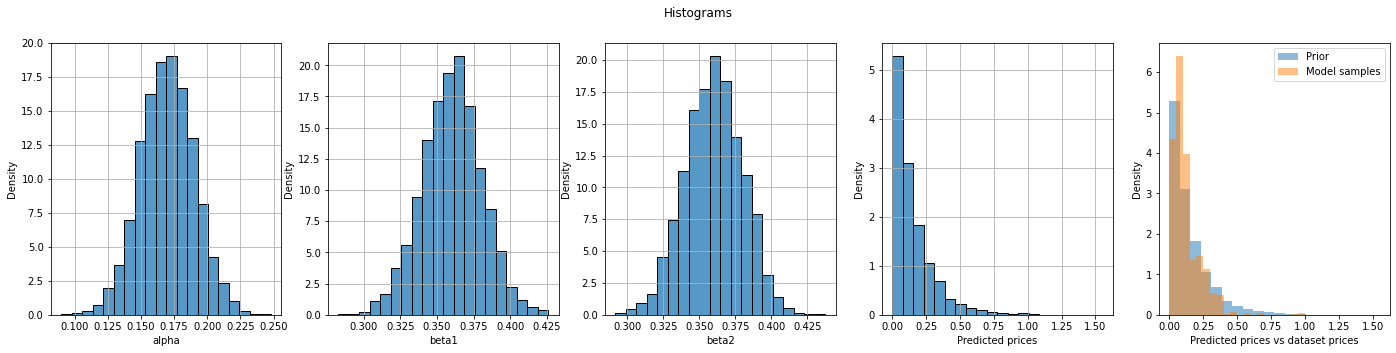

In [16]:
_, ax = plt.subplots(1, 5, figsize=(24, 5))
ax = ax.flatten()
sns.histplot(data=sim_exp_fit_pd, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=sim_exp_fit_pd, x="beta1", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=sim_exp_fit_pd, x="beta2", stat="density", ax=ax[2], bins=BINS)
sns.histplot(data=sim_exp_fit_pd, x="price[1]", stat="density", ax=ax[3], bins=BINS)

ax[4].hist(sim_exp_fit_pd["price[1]"], bins=BINS, alpha=0.5, density=True, label="Prior")
ax[4].hist(audi_a3_2000ccm_standarized["Price"], bins=BINS, alpha=0.5, density=True, label="Model samples")


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel("alpha"), 
ax[1].set_xlabel("beta1"), 
ax[2].set_xlabel("beta2"), 
ax[3].set_xlabel("Predicted prices"), 
ax[4].set_xlabel("Predicted prices vs dataset prices")

ax[4].set_ylabel("Density")
ax[4].legend()
plt.suptitle("Histograms")
plt.show()

## 2.2 Model 1- posterior

In [18]:
model_exp_fit = cmdstanpy.CmdStanModel(stan_file='stan_files/exp_model_fit.stan')

#Parameters

data = {"N": N, 
        "mileage" : np.linspace(0.01,1,N),
        "production_year" : np.linspace(0.01,1,N),
        "mu_a" : mu_a,
        "sig_a" : sig_a,
        "mu_b1" : mu_b1,
        "mu_b2" : mu_b2,
        "sig_b1" : sig_b1,
        "sig_b2" : sig_b2,
        }

sim_exp_fit=model_exp_fit.sample(data=data)
sim_exp_fit_pd = sim_exp_fit.draws_pd()
sim_exp_fit_pd.head()

22:45:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


22:45:58 - cmdstanpy - INFO - CmdStan done processing.


,lp__,accept_stat__
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [ ]:
_, ax = plt.subplots(1, 5, figsize=(24, 5))
ax = ax.flatten()
sns.histplot(data=sim_exp_fit_pd, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=sim_exp_fit_pd, x="beta1", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=sim_exp_fit_pd, x="beta2", stat="density", ax=ax[2], bins=BINS)
sns.histplot(data=sim_exp_fit_pd, x="price[1]", stat="density", ax=ax[3], bins=BINS)

ax[4].hist(sim_exp_fit_pd["price[1]"], bins=BINS, alpha=0.5, density=True, label="Prior")
ax[4].hist(audi_a3_2000ccm_standarized["Price"], bins=BINS, alpha=0.5, density=True, label="Model samples")


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel("alpha"), 
ax[1].set_xlabel("beta1"), 
ax[2].set_xlabel("beta2"), 
ax[3].set_xlabel("Predicted prices"), 
ax[4].set_xlabel("Predicted prices vs dataset prices")

ax[4].set_ylabel("Density")
ax[4].legend()
plt.suptitle("Histograms")
plt.show()

## 2.3 Model 2- prior

## 2.4 Model 2- posterior

# 3. Model comparison